# Simulating Gene Expression Dynamics with CausalRegNet

CausalRegNet is a multiplicative effect SCM that uses a Negative Binomial distribution to simulate realstic scRNA-seq data. Here, we demonstrate how real data from Replogle et al. (2022) can be combined with the CausalRegNet framework to simulate data. We do this for both the observational and interventional setting. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

import lightning.pytorch as pl
from torch.utils.data import DataLoader, TensorDataset

from causalregnet import utils
from causalregnet.simulator import Simulator
from causalregnet.models.nb_fitter import NegativeBinomialFitter

sns.set_context("notebook")
sns.set_theme(style="whitegrid", palette="tab10", font="Arial")
plt.rcParams['figure.figsize'] = [3, 3]

## Fitting to Data from Replogle et al. (2022)

With our code, we provide three files that were derived from the Replogle et al. (2022) dataset according to the cancer gene selection procedure described in the paper. These files include:
- `k562_100_cancer_genes.csv`: expression matrix of 100 genes;
- `k562_targets.csv`: intervention target for each row; 'non-targeting' indicates no intervention;
- `k562_gene_names.csv`: maps ensembl id's (i.e. alternative gene names) to human readable gene names.

We then use the `fit` module from `causalregnet` to fit negative binomial distributions to three genes from this dataset with the aim of simulating data from a random 3 node DAG.

In [13]:
# loading cancer gene dataset

# `k562_100_cancer_genes.csv`: expression matrix
# `k562_targets.csv`: intervention target for each row; 'non-targeting' indicates no intervention
# `k562_gene_names.csv`: maps ensembl id's (i.e. alternative gene names) to human readable gene names

df = pd.read_csv('../causalregnet/data/k562_100_cancer_genes.csv', delim_whitespace=True, header=0)
targets = pd.read_csv('../causalregnet/data/k562_targets.csv', delim_whitespace=True, header=None)
targets.columns = ['gene']
gene_names = pd.read_csv('../causalregnet/data/k562_gene_names.csv', delim_whitespace=True, header=0)

# keep observational samples only
df = df.iloc[np.where(targets == 'non-targeting')[0],:]

# selecting first three genes
idx = [0, 1, 2]

data = torch.tensor(df.to_numpy(), dtype=torch.float32)

fitted_r = []
fitted_p = []

for g in idx:

    dataset = TensorDataset(data[:, g])
    data_loader = DataLoader(dataset, batch_size=1024, shuffle=True)

    model = NegativeBinomialFitter()

    trainer = pl.Trainer(max_epochs=100, log_every_n_steps=100)
    trainer.fit(model, data_loader)

    fitted_r.append(model.r.item())
    fitted_p.append(torch.sigmoid(model.p).item())  # Apply sigmoid to get p in (0, 1)

fitted_r = np.array(fitted_r)
fitted_p = np.array(fitted_p)

fitted_mu = fitted_r * (fitted_p/(1 - fitted_p))
fitted_theta = fitted_r

/var/folders/tn/_g1q08vx4zd1wdycsthwc3vh0000gn/T/ipykernel_69625/943750846.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('../causalregnet/data/k562_100_cancer_genes.csv', delim_whitespace=True, header=0)
/var/folders/tn/_g1q08vx4zd1wdycsthwc3vh0000gn/T/ipykernel_69625/943750846.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  targets = pd.read_csv('../causalregnet/data/k562_targets.csv', delim_whitespace=True, header=None)
/var/folders/tn/_g1q08vx4zd1wdycsthwc3vh0000gn/T/ipykernel_69625/943750846.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gene_names = pd.read_csv('../causalregnet/data/k562_gene_names.csv', delim_whitespace=True, header=0)
GPU available: True (mp

Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 107.88it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 107.38it/s, v_num=1]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 2      | n/a 
---------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 127.34it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 126.57it/s, v_num=2]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 2      | n/a 
---------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 114.94it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 74/74 [00:00<00:00, 114.06it/s, v_num=3]


## Observational Setting

Before simulating data, several user defined parameters must first be set including:
- `mu`: mean expression for each node (here derived from real data);
- `theta`: inverse dispersion for each node (here derived from real data);
- `alpha`: maximum regulatory effect of parents on each node;
- `beta`: minimum regulatory effect of parents on each node;
- `agg_type`: aggregation function to be used (currently the only option is `linear`);
- `reg_constant`: *regulatory adjustment constant*.

The directed acyclic graph `B` is generated using the `utils` module of `causalregnet` and the weight adjacency matrix `W` is subsequently generated as well.

In [14]:
# CausalRegNet parameters
np.random.seed(0)

mu = fitted_mu
theta = fitted_theta
alpha = np.repeat(2, 3)
beta = np.repeat(0.1, 3)
agg_type = 'linear'
reg_constant = np.repeat(1, 3)

B = utils.generate_dag(d=3, m=3)
W = utils.generate_W(B=B, w_ranges=((-2,-0.5), (0.5, 2)))

In [15]:
simulator = Simulator(nnodes=3,
                            mu=mu,
                            theta=theta, 
                            W=W,
                            alpha=alpha,
                            beta=beta,
                            agg_type=agg_type,
                            reg_constant=reg_constant)

simulator.calibrate_sigmoid()

X = simulator.simulate(n_samp=1000)

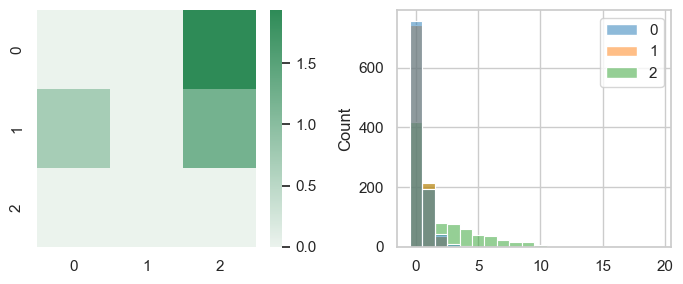

In [16]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(W, cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X, ax=ax[1], bins=np.arange(-0.5, 20.5, step=1))

plt.tight_layout()

## Interventional Setting

Given an observational simulation, generting interventional data is simple as we only need to specify `intervention_type`(i.e. deterministic vs. stochastic) and `intervention_val`(value assigned to intervention target). In the simulatino below we interevene on $I=\{X_1\}$ by setting $X_1=0$ deterministically and do not intervene on the remaining variables $\mathbf{X} \backslash I = \{X_0, X_2\}$.

In [19]:
X_int = simulator.simulate(n_samp=1000, intervention_type='deterministic', intervention_val=[-1, 0, -1])

In [20]:
X_int

array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 2.],
       ...,
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

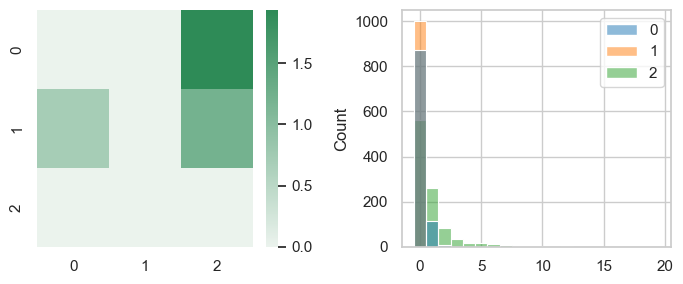

In [21]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(W, cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X_int, ax=ax[1], bins=np.arange(-0.5, 20.5, step=1))

plt.tight_layout()

In [22]:
# average treatment effects
print(X_int.mean(axis=0) - X.mean(axis=0))

[-0.172 -0.31  -1.007]
